In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import json
# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
def get_stock_data(ticker, start='2010-01-01'):
    data = yf.download(ticker, start=start)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

In [12]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [14]:
import os

# Modified function to append results to JSON
def save_results_to_json(ticker, epoch, rmse, mae, mape, r2, filename='results_2010.json'):
    # Check if the file exists and read existing data
    if os.path.isfile(filename):
        with open(filename, 'r') as file:
            try:
                existing_data = json.load(file)
            except json.JSONDecodeError:
                existing_data = []
    else:
        existing_data = []

    # Append new result
    new_result = {
        'Ticker': ticker,
        'Epoch': epoch,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2_Score': r2
    }
    existing_data.append(new_result)

    # Save the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(existing_data, file, indent=4)
    print(f'Results appended to {filename}')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)
    save_results_to_json(ticker,epoch, rmse, mae, mape, r2)
    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")

        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.0380 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0016 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 132.66862800689233
MAE: 106.4031522369051
MAPE: 2.9550387162978033
R^2 Score: -0.6627293519995141
Results appended to results_2010.json


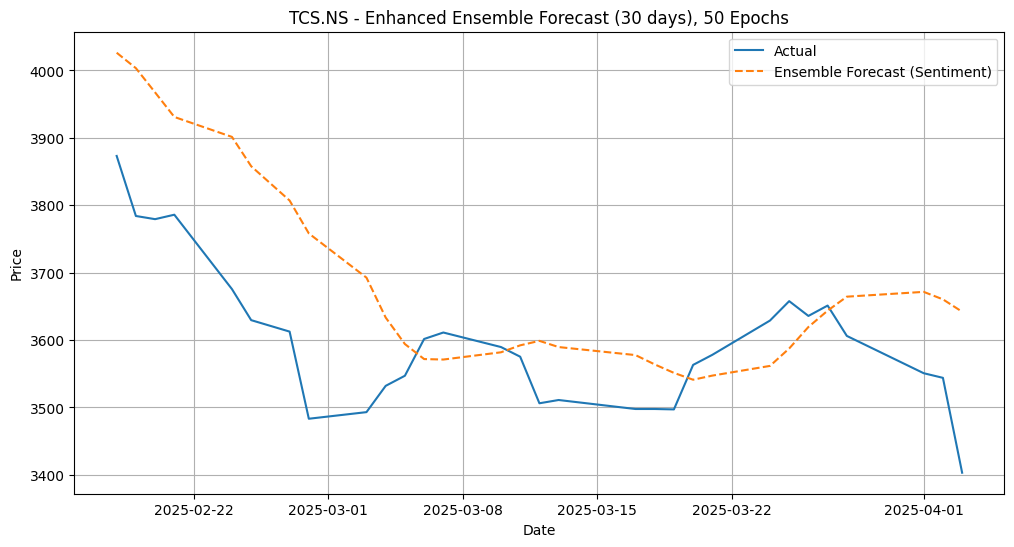

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - loss: 0.0460 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0069 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 10/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 11/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 117

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 201.3619315017228
MAE: 174.6051296780235
MAPE: 4.872218279986271
R^2 Score: -2.8303620367426503
Results appended to results_2010.json


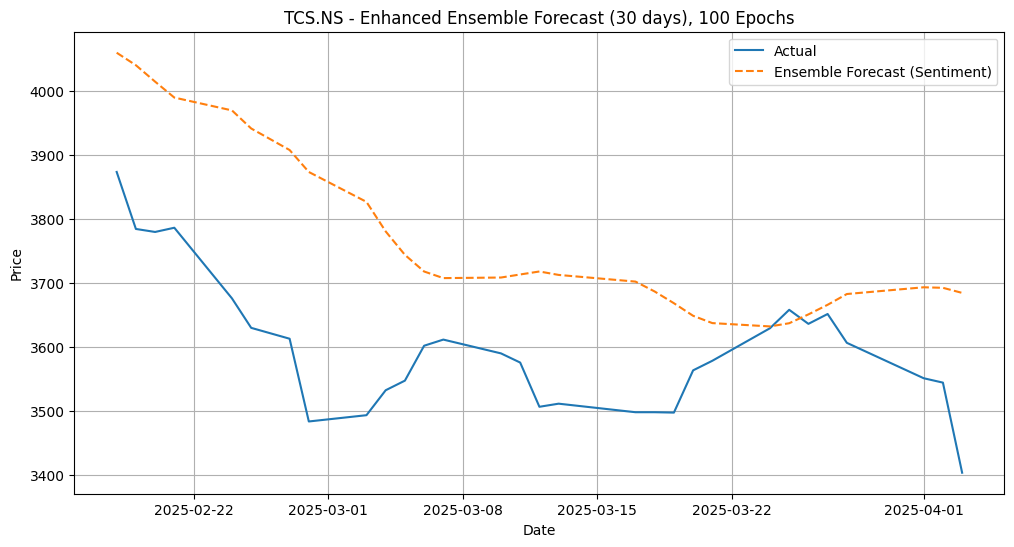

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - loss: 0.0549 - learning_rate: 0.0010
Epoch 2/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 3/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 4/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 5/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 6/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 7/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 8/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 9/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 10/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 11/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
RMSE: 108.60662952053579
MAE: 89.43394348487043
MAPE: 2.4817687539330824
R^2 Score: -0.11428878572515022
Results appended to results_2010.json


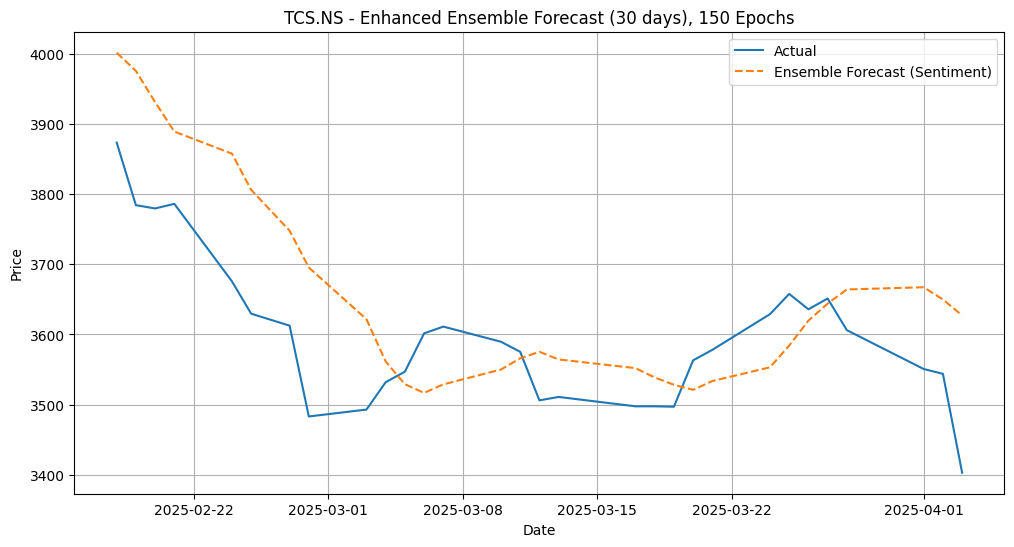

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 63s 116ms/step - loss: 0.0415 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 0.0070 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 9/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 10/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 11/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 134

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
RMSE: 97.40825193759447
MAE: 80.31522820088573
MAPE: 2.2531267192381446
R^2 Score: 0.10649379194203479
Results appended to results_2010.json


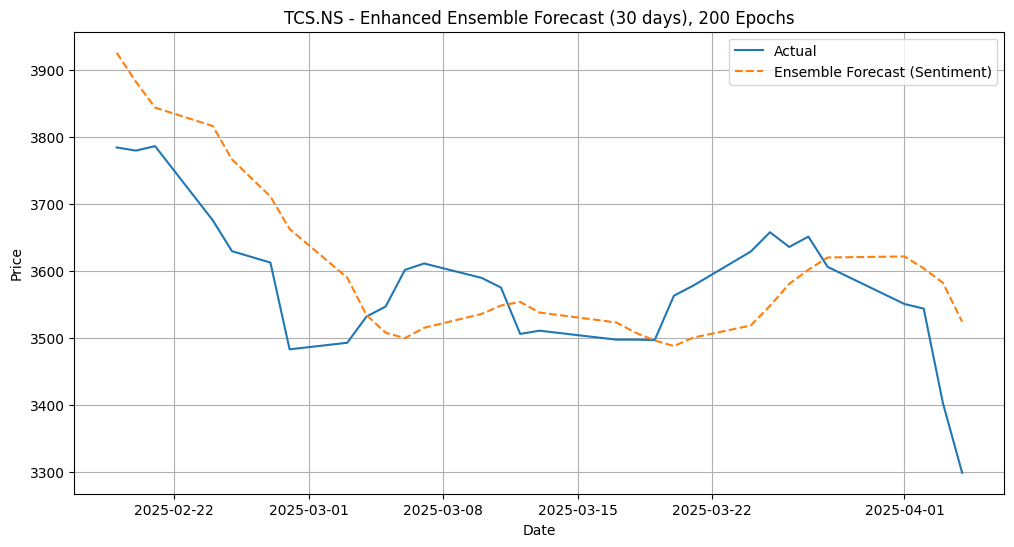

[*********************100%***********************]  1 of 1 completed

Epoch 1/250



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.0281 - learning_rate: 0.0010
Epoch 2/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 3/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 4/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 5/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 6/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 7/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 8/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 9/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 11/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0013 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
RMSE: 101.78036524510424
MAE: 83.31768741011716
MAPE: 2.3379279935718214
R^2 Score: 0.024484700558928374
Results appended to results_2010.json


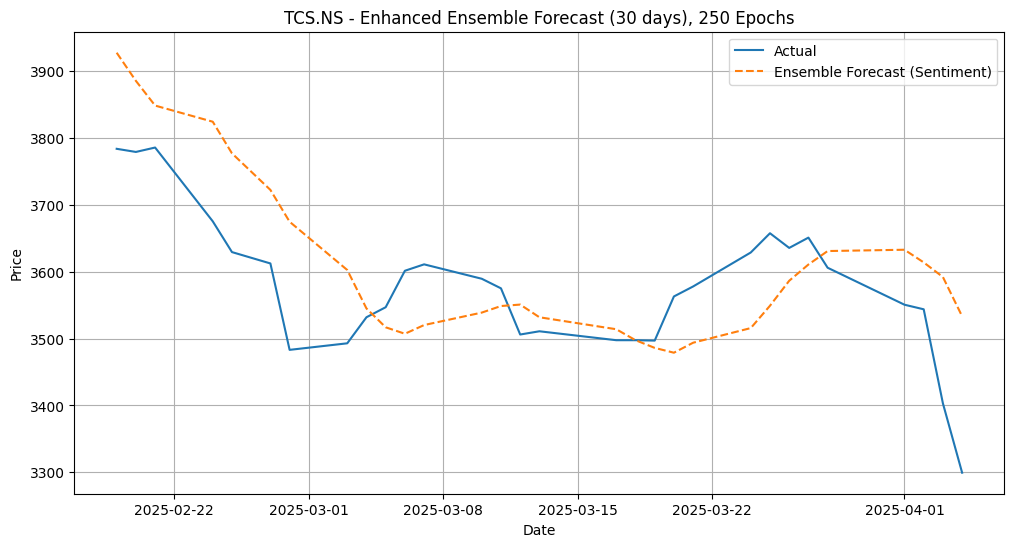

In [17]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.0769 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0017

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
RMSE: 30.33496924945294
MAE: 24.28268279080497
MAPE: 1.951624983423244
R^2 Score: 0.20350384303803493
Results appended to results_2010.json


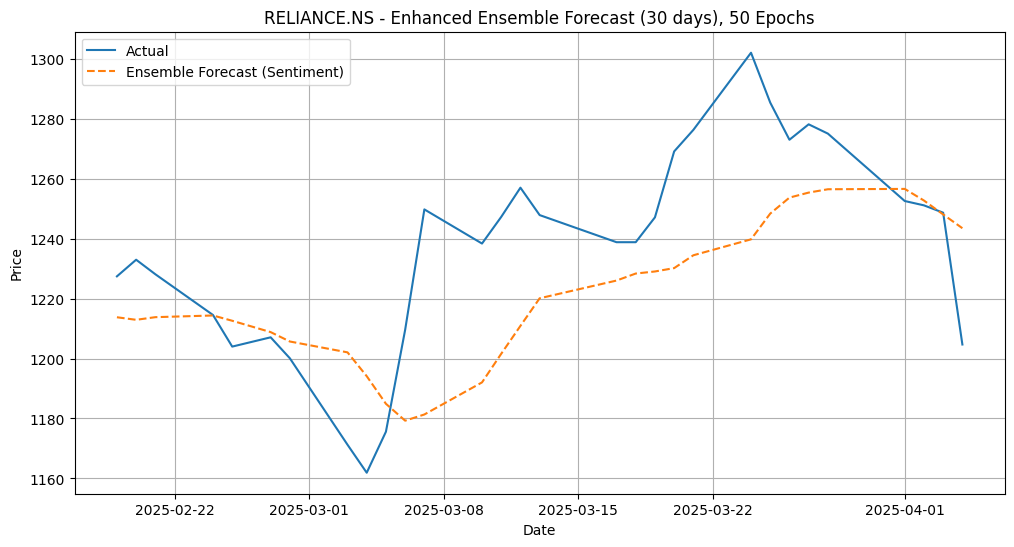

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - loss: 0.0491 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 10/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 11/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
RMSE: 40.38235542853544
MAE: 33.276077471520786
MAPE: 2.671388637164667
R^2 Score: -0.41149667852156724
Results appended to results_2010.json


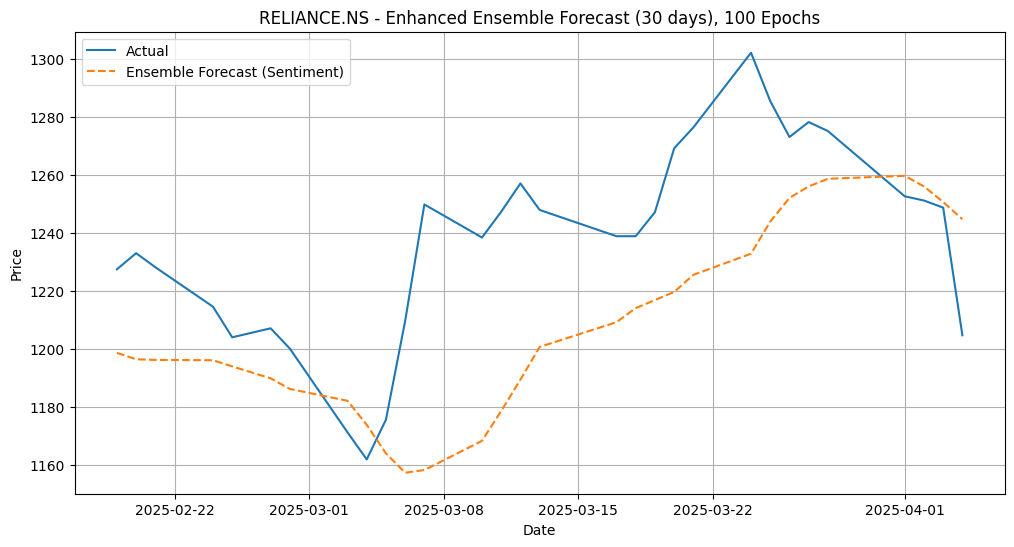

[*********************100%***********************]  1 of 1 completed

Epoch 1/150



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0369 - learning_rate: 0.0010
Epoch 2/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 3/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 4/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 6/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 7/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 10/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 11/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0013 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
RMSE: 24.084358304512822
MAE: 19.19160839695678
MAPE: 1.5592205195173905
R^2 Score: 0.4979271630999228
Results appended to results_2010.json


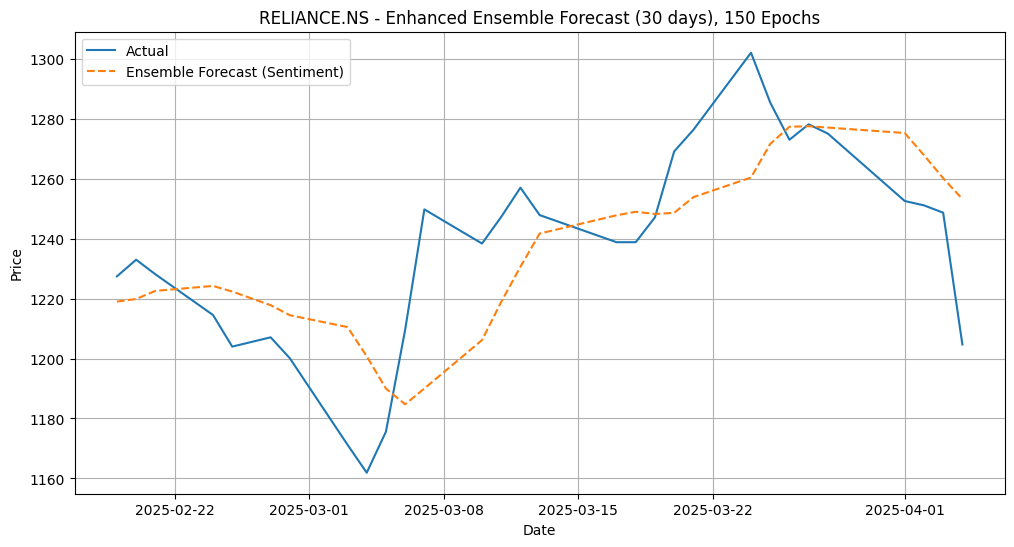

[*********************100%***********************]  1 of 1 completed

Epoch 1/200



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 0.0589 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0086 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 9/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 10/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 11/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
RMSE: 35.98113542038928
MAE: 29.333400056064267
MAPE: 2.3541229081921444
R^2 Score: -0.12058884328715269
Results appended to results_2010.json


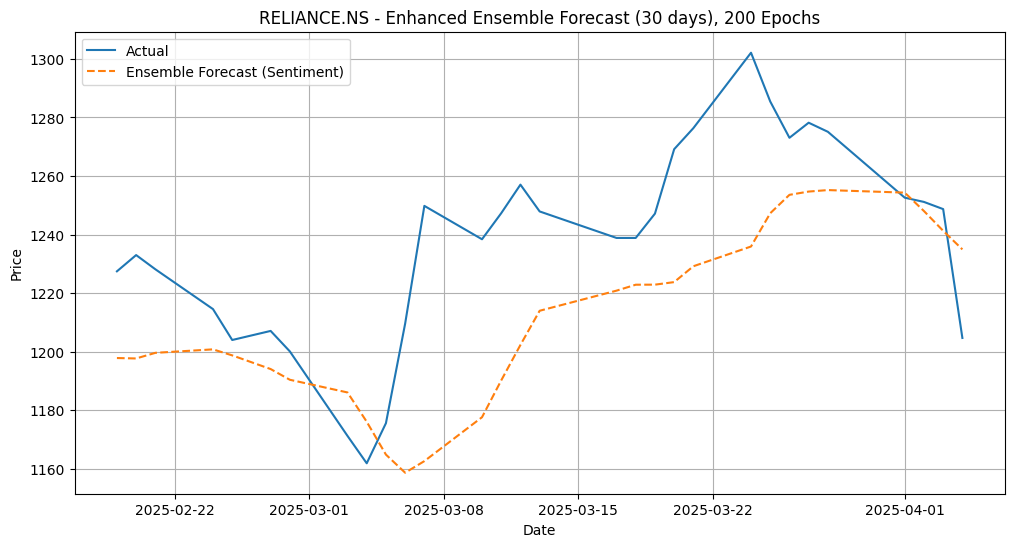

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 152ms/step - loss: 0.0467 - learning_rate: 0.0010
Epoch 2/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 3/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 4/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 7/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 8/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 169ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 11/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 158

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 24.151589577129652
MAE: 20.187417488209228
MAPE: 1.642613475375235
R^2 Score: 0.49512018699290594
Results appended to results_2010.json


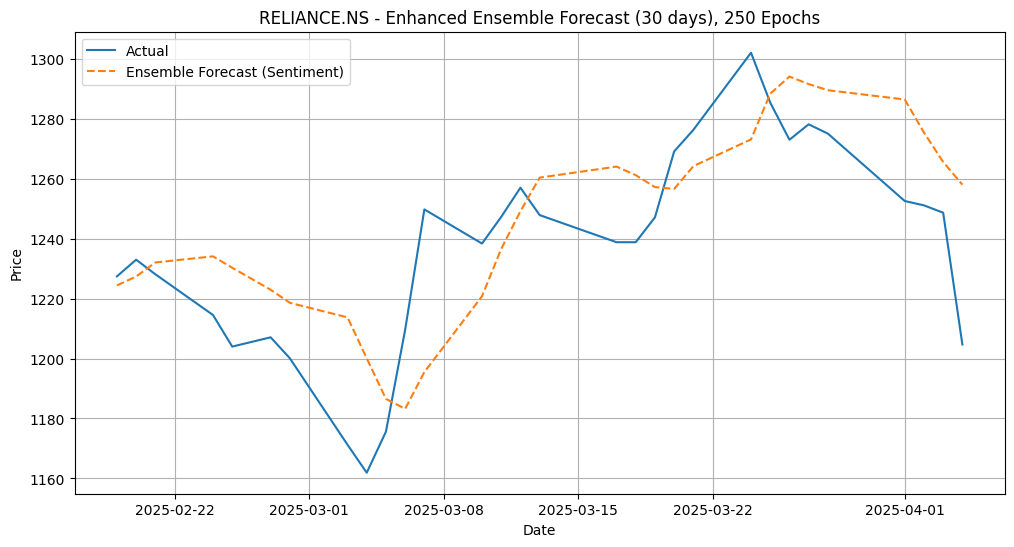

In [18]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - loss: 0.0631 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
📊 Performance Metrics for ^NSEI:
RMSE: 393.75
MAE: 333.08
MAPE: 1.46%
R² Score: 0.3070



[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - loss: 0.0405 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
📊 Performance Metrics for ^CNX100:
RMSE: 422.96
MAE: 363.87
MAPE: 1.57%
R² Score: 0.3384



[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNX500. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


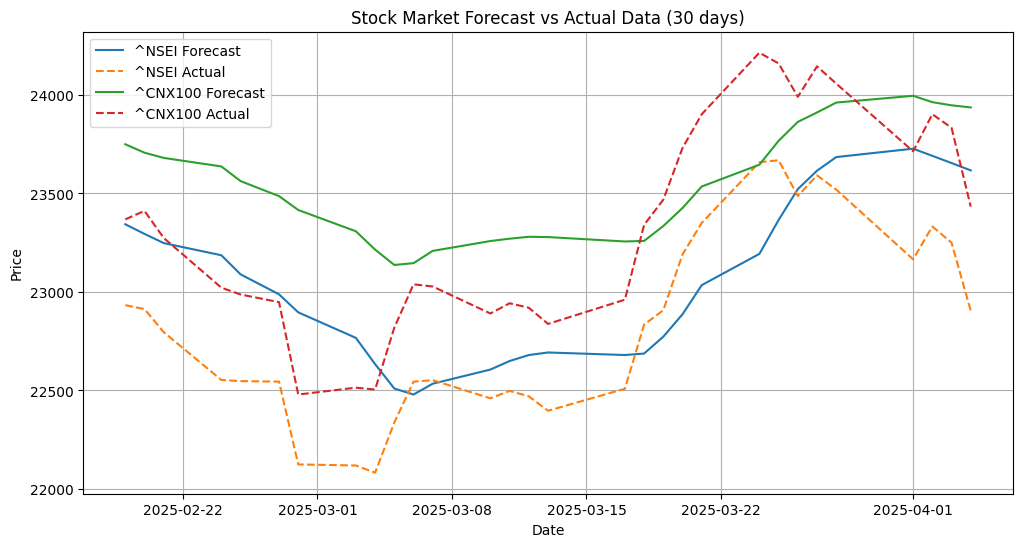

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - loss: 0.0548 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 7.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
📊 Performance Metrics for ^NSEI:
RMSE: 566.82
MAE: 487.09
MAPE: 2.15%
R² Score: -0.4360



[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - loss: 0.0570 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0085 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 8.50

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:


📊 Performance Metrics for ^CNX100:
RMSE: 464.10
MAE: 395.77
MAPE: 1.71%
R² Score: 0.2034



ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNX500. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


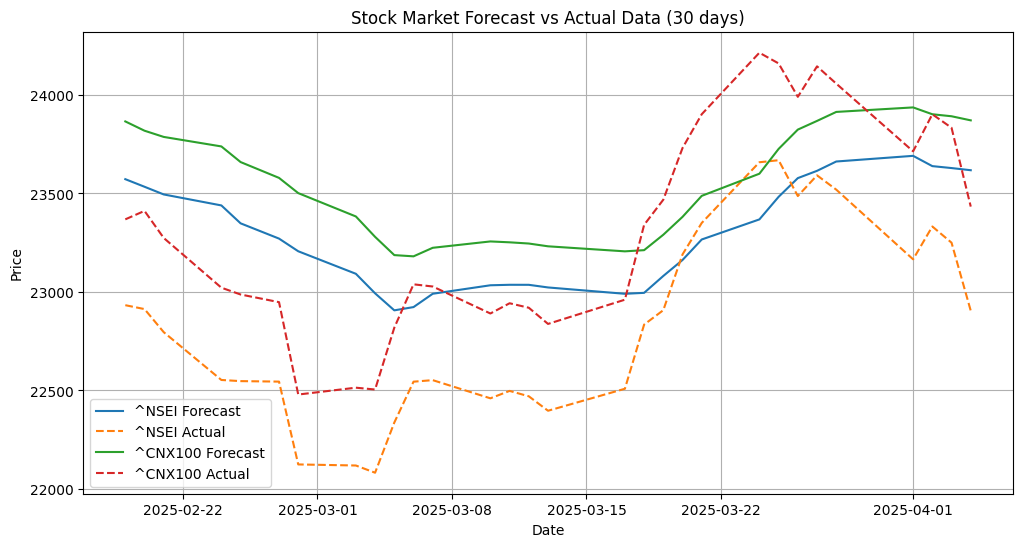

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0578 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.001

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 368.72
MAE: 311.08
MAPE: 1.36%
R² Score: 0.3923



[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - loss: 0.0726 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0054 - learning_rate: 0.0010
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 10/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 11/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


📊 Performance Metrics for ^CNX100:
RMSE: 380.04
MAE: 317.74
MAPE: 1.36%
R² Score: 0.4658

⚠️ Warning: No data found for ^CNX500. Skipping...
⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


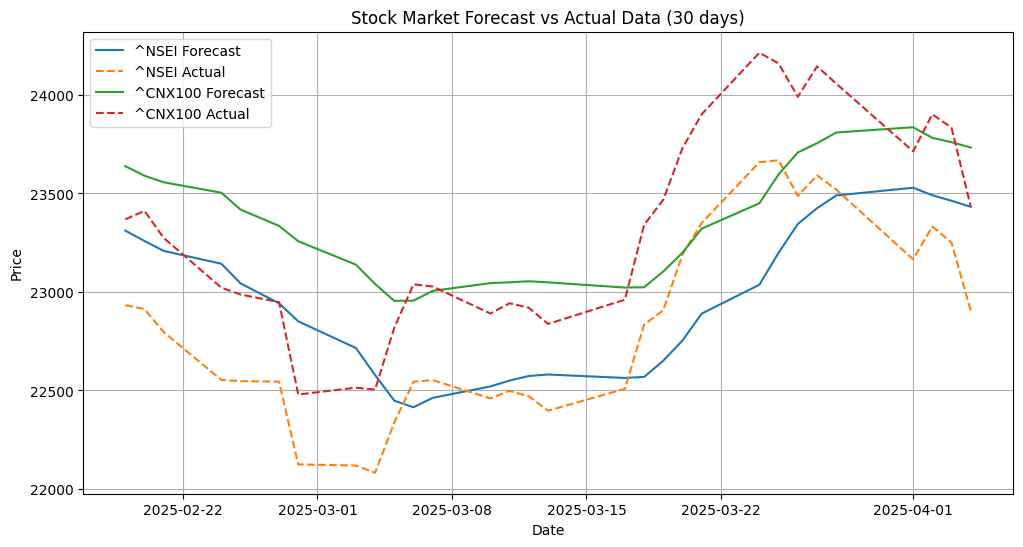

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 0.0432 - learning_rate: 0.0010
Epoch 2/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 3/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 4/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 8/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 11/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 287.36
MAE: 237.29
MAPE: 1.04%
R² Score: 0.6309



[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0524 - learning_rate: 0.0010
Epoch 2/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 3/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 4/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 6/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 10/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


📊 Performance Metrics for ^CNX100:
RMSE: 391.59
MAE: 316.41
MAPE: 1.35%
R² Score: 0.4329

⚠️ Warning: No data found for ^CNX500. Skipping...
⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


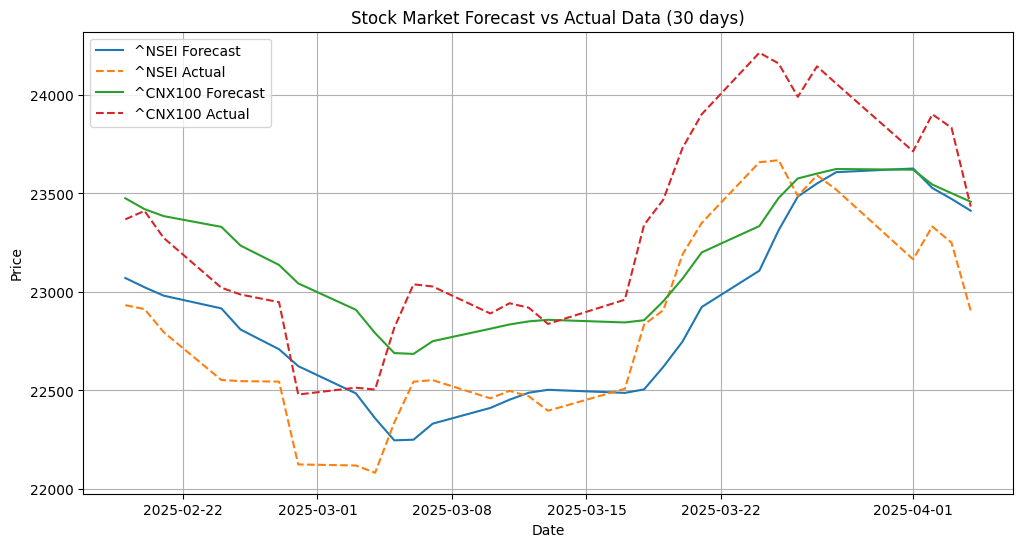

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - loss: 0.0512 - learning_rate: 0.0010
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0096 - learning_rate: 0.0010
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 4/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 5/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
📊 Performance Metrics for ^NSEI:
RMSE: 375.59
MAE: 320.13
MAPE: 1.41%
R² Score: 0.3695



[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - loss: 0.0582 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0077 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 10/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


📊 Performance Metrics for ^CNX100:
RMSE: 468.17
MAE: 408.97
MAPE: 1.76%
R² Score: 0.1894

⚠️ Warning: No data found for ^CNX500. Skipping...
⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


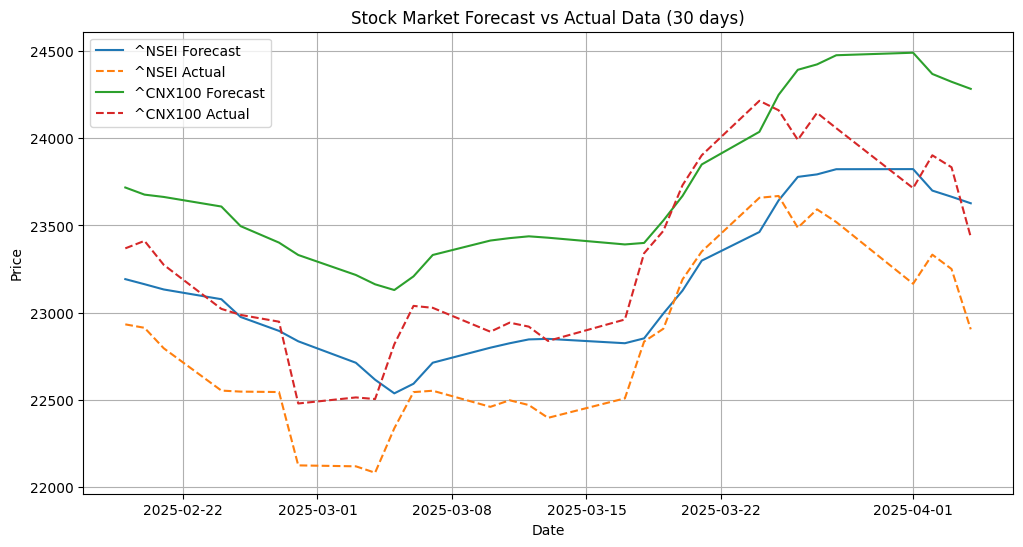

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 0.0660 - learning_rate: 0.0010
Epoch 2/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0082 - learning_rate: 0.0010
Epoch 3/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 4/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 5/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 9.8527e-04 - learning_rate: 0.0010
Epoch 11/250
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 330.96
MAE: 286.59
MAPE: 1.26%
R² Score: 0.5104



[*********************100%***********************]  1 of 1 completed

Epoch 1/250



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 0.0601 - learning_rate: 0.0010
Epoch 2/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 3/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 4/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 5/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 6/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 7/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 8/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 9/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/250
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0011 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


📊 Performance Metrics for ^CNX100:
RMSE: 305.00
MAE: 240.72
MAPE: 1.02%
R² Score: 0.6560

⚠️ Warning: No data found for ^CNX500. Skipping...
⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


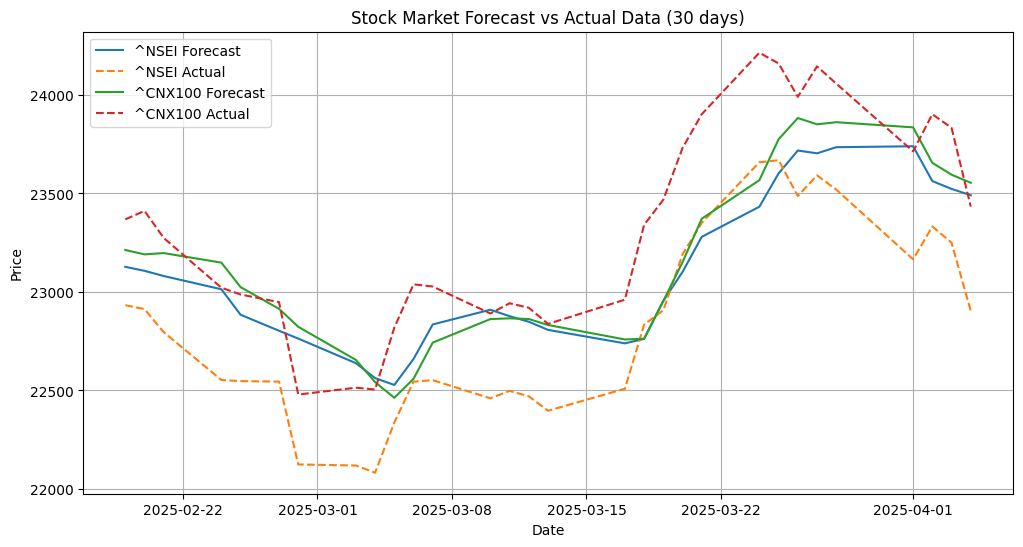

In [ ]:
nifty_indices = ['^NSEI', '^CNX100', '^CNX500', '^CNXMIDCAP']

forecast_multiple_indices(nifty_indices)
forecast_multiple_indices(nifty_indices,epoch=100)
forecast_multiple_indices(nifty_indices,epoch=150)
forecast_multiple_indices(nifty_indices,epoch=200)
forecast_multiple_indices(nifty_indices,epoch=250)
